## Regev circuit implementation :

In this notebook, we propose a qiskit implementation of Regev's algorithm to factorize N = pq, with N<32.
We use the following variable definition :
- n = log(N) : the number of bits to encode N
- d : the dimension of the algorithm
- b_i : as defined in Regev's paper

As we want to achieve small qubits requirement in order to simulate with normal PC, we used the following tricks :
1. for the gaussian superposition, we do not compute the angle in a quantum superposition. We compute them classically and then apply controlled rotation for each value. This allows us to use only n qubits.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from sympy.logic.boolalg import Or, And, Not
from qiskit.circuit.library import QFT
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from qiskit.circuit.classicalfunction import classical_function
from qiskit.circuit.classicalfunction.types import Int1

#This notebook define some utility functions. 
import import_ipynb
import QC_utils as qcu

### Gaussian superposition :


In [2]:
def gaussian_superposition(dimension: int, qbit_per_dim: int, std: int):
    """
        Return a circuit that initialize a gaussian superposition of given dimension.

        We apply controlled rotation to the qbit_per_dim-1 first qubits of each dim. (or log(qpd) if more than 5 qubits per dimension)
        We use the last qubits as ancilla for the controlled rotation and then apply h to it.
    """
    
    #Compute an array that contains the discrete gaussian values.
    prob_values = qcu.getProbValue(qbit_per_dim, qcu.gaussian_pmf, std)
    
    # Initialize a quantum circuit for 1 dim. with the correct number of qubits (on ancilla is used for the controlled rotation)
    dim1_qc = QuantumCircuit(qbit_per_dim)
    
    #if we have more than 5 qubits per dim, we apply the rotation only to the log() first qubits.
    if qbit_per_dim >= 3:
        if qbit_per_dim<6:
            limit = qbit_per_dim-1
        else:
            limit = max(np.ceil(np.log2(qbit_per_dim)),5)
        qcu.limited_split_qc(dim1_qc, prob_values,  "", 0, int(qbit_per_dim-1), int(limit))
        nqb = dim1_qc.num_qubits
        for x in range(int(limit), qbit_per_dim):
            dim1_qc.h(x)
        
        #reorder qbits (resverse the order)
        for x in range(math.floor(nqb/2)):
            dim1_qc.swap(x, nqb-x-1)
        
    else:
        return null;
    
    
    
    
    # Start with the first copy
    big_qc = dim1_qc
    
    # Tensor product the small circuit with itself n-1 times
    for _ in range(dimension - 1):
        big_qc = big_qc.tensor(dim1_qc)
    return(big_qc)

In [3]:
def test_and_plot_gaussian_superposition(dimension, qbits_per_dim, std):
    """
        For testing purpose of the gaussian state preparation.
        
        This create a circuit for a gaussian superposition, simulate it (noiseless), and plot the outcome
    """
    
    qbits_count = dimension*qbits_per_dim

    inst_gauss = gaussian_superposition(dimension, qbits_per_dim, std).to_instruction()
    qc = QuantumCircuit(qbits_count)
    qbits_array = range(qbits_count)
    qc.append(inst_gauss, qbits_array)

    statevector = Statevector.from_instruction(qc)

    # Calculate probabilities by taking the diagonal elements of the reduced density matrix
    probabilities = statevector.probabilities(qbits_array)

    #format output and plot
    data = qcu.generate_labels(probabilities, qbits_per_dim, dimension)
    if dimension==1:
        print(data)
        plot_histogram(data, figsize=(30,5))  # Set figure size here
    if dimension==2:
        qcu.plot_2d_distribution(data)
    if dimension==3:
        qcu.plot_3d_distribution(data)

In [4]:
test_and_plot_gaussian_superposition(1, 10, 50)

{416: 1.906029894161411e-05, 417: 1.906029894161411e-05, 418: 1.906029894161411e-05, 419: 1.906029894161411e-05, 420: 1.906029894161411e-05, 421: 1.906029894161411e-05, 422: 1.906029894161411e-05, 423: 1.906029894161411e-05, 424: 1.906029894161411e-05, 425: 1.906029894161411e-05, 426: 1.906029894161411e-05, 427: 1.906029894161411e-05, 428: 1.906029894161411e-05, 429: 1.906029894161411e-05, 430: 1.906029894161411e-05, 431: 1.906029894161411e-05, 432: 1.906029894161411e-05, 433: 1.906029894161411e-05, 434: 1.906029894161411e-05, 435: 1.906029894161411e-05, 436: 1.906029894161411e-05, 437: 1.906029894161411e-05, 438: 1.906029894161411e-05, 439: 1.906029894161411e-05, 440: 1.906029894161411e-05, 441: 1.906029894161411e-05, 442: 1.906029894161411e-05, 443: 1.906029894161411e-05, 444: 1.906029894161411e-05, 445: 1.906029894161411e-05, 446: 1.906029894161411e-05, 447: 1.906029894161411e-05, 448: 0.0015936012883758645, 449: 0.0015936012883758645, 450: 0.0015936012883758645, 451: 0.001593601288

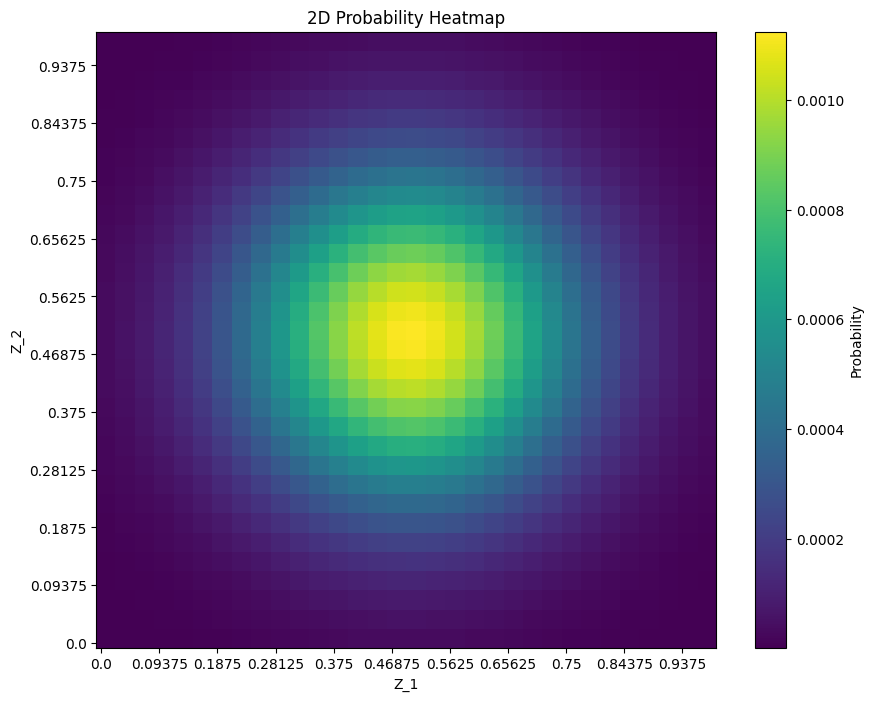

In [5]:
test_and_plot_gaussian_superposition(2, 6, 30)

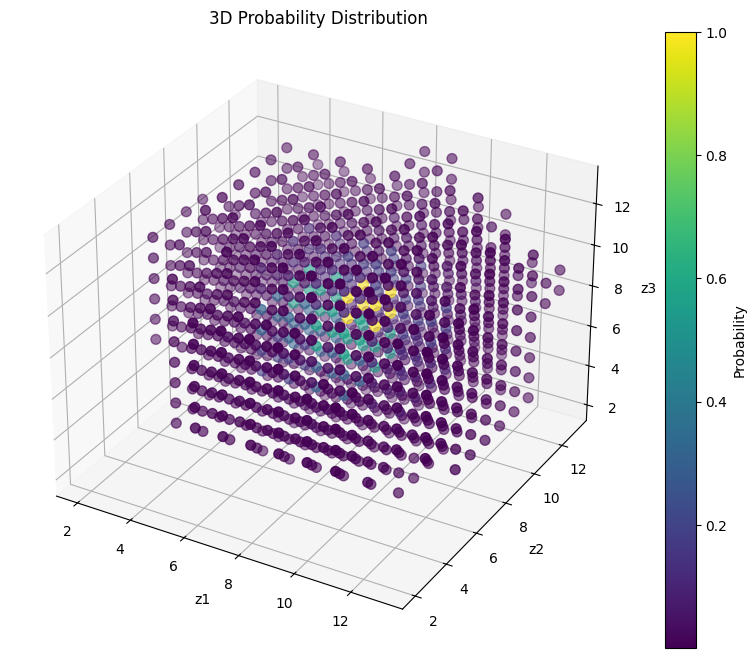

In [6]:
test_and_plot_gaussian_superposition(3, 4, 3)

### Modular Exponentiation :

For this parts, we used hardcoded boolean function of the operation needed. Implementing multiplication and squaring gates would require more qubits than what we can afford.

The definition of the boolean function for each bits for several instances are define below. They were generated using simple brute force algorithm from the truth table.

In [7]:
#N = 21, bi = {2, 5}


@classical_function
def bBit0(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1, x8: Int1, x9: Int1) -> Int1:
    
    return not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0

#def bBit1 => always zero so we don't compute it to save ressources.

    
@classical_function
def bBit2(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1, x8: Int1, x9: Int1) -> Int1:
    return not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0

#def bBit3 => always zero so we don't compute it to save ressources.

@classical_function
def bBit4(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1, x8: Int1, x9: Int1) -> Int1:
    
    return not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and not x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and not x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and not x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and x8 and x7 and not x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and not x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or x9 and x8 and not x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or x9 and x8 and not x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or not x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and not x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and x0 or x9 and not x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and not x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and x1 and not x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and x0 or not x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and x0 or not x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and not x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and not x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and x2 and x1 and not x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and not x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and x3 and x2 and not x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and not x3 and not x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and not x4 and not x3 and x2 and x1 and x0 or x9 and x8 and x7 and x6 and x5 and x4 and x3 and x2 and x1 and x0

bits_function_21_2_5 = [bBit0, None, bBit2, None, bBit4]

In [20]:
#N = 14, bi = {3,5}
@classical_function
def bBit0(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1) -> Int1:
    
    return (x0 and x1 and x2 and x3 and x4 and x5 and x6 and x7) or (x0 and x1 and x2 and x3 and x4 and x5 and x6 and not x7) or (x0 and x1 and x2 and x3 and x4 and x5 and x7 and not x6) or (x0 and x1 and x2 and x3 and x4 and x6 and x7 and not x5) or (x0 and x1 and x2 and x3 and x5 and x6 and x7 and not x4) or (x0 and x1 and x2 and x4 and x5 and x6 and x7 and not x3) or (x0 and x1 and x3 and x4 and x5 and x6 and x7 and not x2) or (x0 and x2 and x3 and x4 and x5 and x6 and x7 and not x1) or (x1 and x2 and x3 and x4 and x5 and x6 and x7 and not x0) or (x0 and x1 and x2 and x3 and x4 and x5 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x4 and x6 and not x5 and not x7) or (x0 and x1 and x2 and x3 and x4 and x7 and not x5 and not x6) or (x0 and x1 and x2 and x3 and x5 and x6 and not x4 and not x7) or (x0 and x1 and x2 and x3 and x5 and x7 and not x4 and not x6) or (x0 and x1 and x2 and x3 and x6 and x7 and not x4 and not x5) or (x0 and x1 and x2 and x4 and x5 and x6 and not x3 and not x7) or (x0 and x1 and x2 and x4 and x5 and x7 and not x3 and not x6) or (x0 and x1 and x2 and x4 and x6 and x7 and not x3 and not x5) or (x0 and x1 and x2 and x5 and x6 and x7 and not x3 and not x4) or (x0 and x1 and x3 and x4 and x5 and x6 and not x2 and not x7) or (x0 and x1 and x3 and x4 and x5 and x7 and not x2 and not x6) or (x0 and x1 and x3 and x4 and x6 and x7 and not x2 and not x5) or (x0 and x1 and x3 and x5 and x6 and x7 and not x2 and not x4) or (x0 and x1 and x4 and x5 and x6 and x7 and not x2 and not x3) or (x0 and x2 and x3 and x4 and x5 and x6 and not x1 and not x7) or (x0 and x2 and x3 and x4 and x5 and x7 and not x1 and not x6) or (x0 and x2 and x3 and x4 and x6 and x7 and not x1 and not x5) or (x0 and x2 and x3 and x5 and x6 and x7 and not x1 and not x4) or (x0 and x2 and x4 and x5 and x6 and x7 and not x1 and not x3) or (x0 and x3 and x4 and x5 and x6 and x7 and not x1 and not x2) or (x1 and x2 and x3 and x4 and x5 and x6 and not x0 and not x7) or (x1 and x2 and x3 and x4 and x5 and x7 and not x0 and not x6) or (x1 and x2 and x3 and x4 and x6 and x7 and not x0 and not x5) or (x1 and x2 and x3 and x5 and x6 and x7 and not x0 and not x4) or (x1 and x2 and x4 and x5 and x6 and x7 and not x0 and not x3) or (x1 and x3 and x4 and x5 and x6 and x7 and not x0 and not x2) or (x2 and x3 and x4 and x5 and x6 and x7 and not x0 and not x1) or (x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x5 and not x4 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x6 and not x4 and not x5 and not x7) or (x0 and x1 and x2 and x3 and x7 and not x4 and not x5 and not x6) or (x0 and x1 and x2 and x4 and x5 and not x3 and not x6 and not x7) or (x0 and x1 and x2 and x4 and x6 and not x3 and not x5 and not x7) or (x0 and x1 and x2 and x4 and x7 and not x3 and not x5 and not x6) or (x0 and x1 and x2 and x5 and x6 and not x3 and not x4 and not x7) or (x0 and x1 and x2 and x5 and x7 and not x3 and not x4 and not x6) or (x0 and x1 and x2 and x6 and x7 and not x3 and not x4 and not x5) or (x0 and x1 and x3 and x4 and x5 and not x2 and not x6 and not x7) or (x0 and x1 and x3 and x4 and x6 and not x2 and not x5 and not x7) or (x0 and x1 and x3 and x4 and x7 and not x2 and not x5 and not x6) or (x0 and x1 and x3 and x5 and x6 and not x2 and not x4 and not x7) or (x0 and x1 and x3 and x5 and x7 and not x2 and not x4 and not x6) or (x0 and x1 and x3 and x6 and x7 and not x2 and not x4 and not x5) or (x0 and x1 and x4 and x5 and x6 and not x2 and not x3 and not x7) or (x0 and x1 and x4 and x5 and x7 and not x2 and not x3 and not x6) or (x0 and x1 and x4 and x6 and x7 and not x2 and not x3 and not x5) or (x0 and x1 and x5 and x6 and x7 and not x2 and not x3 and not x4) or (x0 and x2 and x3 and x4 and x5 and not x1 and not x6 and not x7) or (x0 and x2 and x3 and x4 and x6 and not x1 and not x5 and not x7) or (x0 and x2 and x3 and x4 and x7 and not x1 and not x5 and not x6) or (x0 and x2 and x3 and x5 and x6 and not x1 and not x4 and not x7) or (x0 and x2 and x3 and x5 and x7 and not x1 and not x4 and not x6) or (x0 and x2 and x3 and x6 and x7 and not x1 and not x4 and not x5) or (x0 and x2 and x4 and x5 and x6 and not x1 and not x3 and not x7) or (x0 and x2 and x4 and x5 and x7 and not x1 and not x3 and not x6) or (x0 and x2 and x4 and x6 and x7 and not x1 and not x3 and not x5) or (x0 and x2 and x5 and x6 and x7 and not x1 and not x3 and not x4) or (x0 and x3 and x4 and x5 and x6 and not x1 and not x2 and not x7) or (x0 and x3 and x4 and x5 and x7 and not x1 and not x2 and not x6) or (x0 and x3 and x4 and x6 and x7 and not x1 and not x2 and not x5) or (x0 and x3 and x5 and x6 and x7 and not x1 and not x2 and not x4) or (x0 and x4 and x5 and x6 and x7 and not x1 and not x2 and not x3) or (x1 and x2 and x3 and x4 and x5 and not x0 and not x6 and not x7) or (x1 and x2 and x3 and x4 and x6 and not x0 and not x5 and not x7) or (x1 and x2 and x3 and x4 and x7 and not x0 and not x5 and not x6) or (x1 and x2 and x3 and x5 and x6 and not x0 and not x4 and not x7) or (x1 and x2 and x3 and x5 and x7 and not x0 and not x4 and not x6) or (x1 and x2 and x3 and x6 and x7 and not x0 and not x4 and not x5) or (x1 and x2 and x4 and x5 and x6 and not x0 and not x3 and not x7) or (x1 and x2 and x4 and x5 and x7 and not x0 and not x3 and not x6) or (x1 and x2 and x4 and x6 and x7 and not x0 and not x3 and not x5) or (x1 and x2 and x5 and x6 and x7 and not x0 and not x3 and not x4) or (x1 and x3 and x4 and x5 and x6 and not x0 and not x2 and not x7) or (x1 and x3 and x4 and x5 and x7 and not x0 and not x2 and not x6) or (x1 and x3 and x4 and x6 and x7 and not x0 and not x2 and not x5) or (x1 and x3 and x5 and x6 and x7 and not x0 and not x2 and not x4) or (x1 and x4 and x5 and x6 and x7 and not x0 and not x2 and not x3) or (x2 and x3 and x4 and x5 and x6 and not x0 and not x1 and not x7) or (x2 and x3 and x4 and x5 and x7 and not x0 and not x1 and not x6) or (x2 and x3 and x4 and x6 and x7 and not x0 and not x1 and not x5) or (x2 and x3 and x5 and x6 and x7 and not x0 and not x1 and not x4) or (x2 and x4 and x5 and x6 and x7 and not x0 and not x1 and not x3) or (x3 and x4 and x5 and x6 and x7 and not x0 and not x1 and not x2) or (x0 and x1 and x2 and x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x2 and x4 and not x3 and not x5 and not x6 and not x7) or (x0 and x1 and x2 and x5 and not x3 and not x4 and not x6 and not x7) or (x0 and x1 and x2 and x6 and not x3 and not x4 and not x5 and not x7) or (x0 and x1 and x2 and x7 and not x3 and not x4 and not x5 and not x6) or (x0 and x1 and x3 and x4 and not x2 and not x5 and not x6 and not x7) or (x0 and x1 and x3 and x5 and not x2 and not x4 and not x6 and not x7) or (x0 and x1 and x3 and x6 and not x2 and not x4 and not x5 and not x7) or (x0 and x1 and x3 and x7 and not x2 and not x4 and not x5 and not x6) or (x0 and x1 and x4 and x5 and not x2 and not x3 and not x6 and not x7) or (x0 and x1 and x4 and x6 and not x2 and not x3 and not x5 and not x7) or (x0 and x1 and x4 and x7 and not x2 and not x3 and not x5 and not x6) or (x0 and x1 and x5 and x6 and not x2 and not x3 and not x4 and not x7) or (x0 and x1 and x5 and x7 and not x2 and not x3 and not x4 and not x6) or (x0 and x1 and x6 and x7 and not x2 and not x3 and not x4 and not x5) or (x0 and x2 and x3 and x4 and not x1 and not x5 and not x6 and not x7) or (x0 and x2 and x3 and x5 and not x1 and not x4 and not x6 and not x7) or (x0 and x2 and x3 and x6 and not x1 and not x4 and not x5 and not x7) or (x0 and x2 and x3 and x7 and not x1 and not x4 and not x5 and not x6) or (x0 and x2 and x4 and x5 and not x1 and not x3 and not x6 and not x7) or (x0 and x2 and x4 and x6 and not x1 and not x3 and not x5 and not x7) or (x0 and x2 and x4 and x7 and not x1 and not x3 and not x5 and not x6) or (x0 and x2 and x5 and x6 and not x1 and not x3 and not x4 and not x7) or (x0 and x2 and x5 and x7 and not x1 and not x3 and not x4 and not x6) or (x0 and x2 and x6 and x7 and not x1 and not x3 and not x4 and not x5) or (x0 and x3 and x4 and x5 and not x1 and not x2 and not x6 and not x7) or (x0 and x3 and x4 and x6 and not x1 and not x2 and not x5 and not x7) or (x0 and x3 and x4 and x7 and not x1 and not x2 and not x5 and not x6) or (x0 and x3 and x5 and x6 and not x1 and not x2 and not x4 and not x7) or (x0 and x3 and x5 and x7 and not x1 and not x2 and not x4 and not x6) or (x0 and x3 and x6 and x7 and not x1 and not x2 and not x4 and not x5) or (x0 and x4 and x5 and x6 and not x1 and not x2 and not x3 and not x7) or (x0 and x4 and x5 and x7 and not x1 and not x2 and not x3 and not x6) or (x0 and x4 and x6 and x7 and not x1 and not x2 and not x3 and not x5) or (x0 and x5 and x6 and x7 and not x1 and not x2 and not x3 and not x4) or (x1 and x2 and x3 and x4 and not x0 and not x5 and not x6 and not x7) or (x1 and x2 and x3 and x5 and not x0 and not x4 and not x6 and not x7) or (x1 and x2 and x3 and x6 and not x0 and not x4 and not x5 and not x7) or (x1 and x2 and x3 and x7 and not x0 and not x4 and not x5 and not x6) or (x1 and x2 and x4 and x5 and not x0 and not x3 and not x6 and not x7) or (x1 and x2 and x4 and x6 and not x0 and not x3 and not x5 and not x7) or (x1 and x2 and x4 and x7 and not x0 and not x3 and not x5 and not x6) or (x1 and x2 and x5 and x6 and not x0 and not x3 and not x4 and not x7) or (x1 and x2 and x5 and x7 and not x0 and not x3 and not x4 and not x6) or (x1 and x2 and x6 and x7 and not x0 and not x3 and not x4 and not x5) or (x1 and x3 and x4 and x5 and not x0 and not x2 and not x6 and not x7) or (x1 and x3 and x4 and x6 and not x0 and not x2 and not x5 and not x7) or (x1 and x3 and x4 and x7 and not x0 and not x2 and not x5 and not x6) or (x1 and x3 and x5 and x6 and not x0 and not x2 and not x4 and not x7) or (x1 and x3 and x5 and x7 and not x0 and not x2 and not x4 and not x6) or (x1 and x3 and x6 and x7 and not x0 and not x2 and not x4 and not x5) or (x1 and x4 and x5 and x6 and not x0 and not x2 and not x3 and not x7) or (x1 and x4 and x5 and x7 and not x0 and not x2 and not x3 and not x6) or (x1 and x4 and x6 and x7 and not x0 and not x2 and not x3 and not x5) or (x1 and x5 and x6 and x7 and not x0 and not x2 and not x3 and not x4) or (x2 and x3 and x4 and x5 and not x0 and not x1 and not x6 and not x7) or (x2 and x3 and x4 and x6 and not x0 and not x1 and not x5 and not x7) or (x2 and x3 and x4 and x7 and not x0 and not x1 and not x5 and not x6) or (x2 and x3 and x5 and x6 and not x0 and not x1 and not x4 and not x7) or (x2 and x3 and x5 and x7 and not x0 and not x1 and not x4 and not x6) or (x2 and x3 and x6 and x7 and not x0 and not x1 and not x4 and not x5) or (x2 and x4 and x5 and x6 and not x0 and not x1 and not x3 and not x7) or (x2 and x4 and x5 and x7 and not x0 and not x1 and not x3 and not x6) or (x2 and x4 and x6 and x7 and not x0 and not x1 and not x3 and not x5) or (x2 and x5 and x6 and x7 and not x0 and not x1 and not x3 and not x4) or (x3 and x4 and x5 and x6 and not x0 and not x1 and not x2 and not x7) or (x3 and x4 and x5 and x7 and not x0 and not x1 and not x2 and not x6) or (x3 and x4 and x6 and x7 and not x0 and not x1 and not x2 and not x5) or (x3 and x5 and x6 and x7 and not x0 and not x1 and not x2 and not x4) or (x4 and x5 and x6 and x7 and not x0 and not x1 and not x2 and not x3) or (x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x3 and not x2 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x4 and not x2 and not x3 and not x5 and not x6 and not x7) or (x0 and x1 and x5 and not x2 and not x3 and not x4 and not x6 and not x7) or (x0 and x1 and x6 and not x2 and not x3 and not x4 and not x5 and not x7) or (x0 and x1 and x7 and not x2 and not x3 and not x4 and not x5 and not x6) or (x0 and x2 and x3 and not x1 and not x4 and not x5 and not x6 and not x7) or (x0 and x2 and x4 and not x1 and not x3 and not x5 and not x6 and not x7) or (x0 and x2 and x5 and not x1 and not x3 and not x4 and not x6 and not x7) or (x0 and x2 and x6 and not x1 and not x3 and not x4 and not x5 and not x7) or (x0 and x2 and x7 and not x1 and not x3 and not x4 and not x5 and not x6) or (x0 and x3 and x4 and not x1 and not x2 and not x5 and not x6 and not x7) or (x0 and x3 and x5 and not x1 and not x2 and not x4 and not x6 and not x7) or (x0 and x3 and x6 and not x1 and not x2 and not x4 and not x5 and not x7) or (x0 and x3 and x7 and not x1 and not x2 and not x4 and not x5 and not x6) or (x0 and x4 and x5 and not x1 and not x2 and not x3 and not x6 and not x7) or (x0 and x4 and x6 and not x1 and not x2 and not x3 and not x5 and not x7) or (x0 and x4 and x7 and not x1 and not x2 and not x3 and not x5 and not x6) or (x0 and x5 and x6 and not x1 and not x2 and not x3 and not x4 and not x7) or (x0 and x5 and x7 and not x1 and not x2 and not x3 and not x4 and not x6) or (x0 and x6 and x7 and not x1 and not x2 and not x3 and not x4 and not x5) or (x1 and x2 and x3 and not x0 and not x4 and not x5 and not x6 and not x7) or (x1 and x2 and x4 and not x0 and not x3 and not x5 and not x6 and not x7) or (x1 and x2 and x5 and not x0 and not x3 and not x4 and not x6 and not x7) or (x1 and x2 and x6 and not x0 and not x3 and not x4 and not x5 and not x7) or (x1 and x2 and x7 and not x0 and not x3 and not x4 and not x5 and not x6) or (x1 and x3 and x4 and not x0 and not x2 and not x5 and not x6 and not x7) or (x1 and x3 and x5 and not x0 and not x2 and not x4 and not x6 and not x7) or (x1 and x3 and x6 and not x0 and not x2 and not x4 and not x5 and not x7) or (x1 and x3 and x7 and not x0 and not x2 and not x4 and not x5 and not x6) or (x1 and x4 and x5 and not x0 and not x2 and not x3 and not x6 and not x7) or (x1 and x4 and x6 and not x0 and not x2 and not x3 and not x5 and not x7) or (x1 and x4 and x7 and not x0 and not x2 and not x3 and not x5 and not x6) or (x1 and x5 and x6 and not x0 and not x2 and not x3 and not x4 and not x7) or (x1 and x5 and x7 and not x0 and not x2 and not x3 and not x4 and not x6) or (x1 and x6 and x7 and not x0 and not x2 and not x3 and not x4 and not x5) or (x2 and x3 and x4 and not x0 and not x1 and not x5 and not x6 and not x7) or (x2 and x3 and x5 and not x0 and not x1 and not x4 and not x6 and not x7) or (x2 and x3 and x6 and not x0 and not x1 and not x4 and not x5 and not x7) or (x2 and x3 and x7 and not x0 and not x1 and not x4 and not x5 and not x6) or (x2 and x4 and x5 and not x0 and not x1 and not x3 and not x6 and not x7) or (x2 and x4 and x6 and not x0 and not x1 and not x3 and not x5 and not x7) or (x2 and x4 and x7 and not x0 and not x1 and not x3 and not x5 and not x6) or (x2 and x5 and x6 and not x0 and not x1 and not x3 and not x4 and not x7) or (x2 and x5 and x7 and not x0 and not x1 and not x3 and not x4 and not x6) or (x2 and x6 and x7 and not x0 and not x1 and not x3 and not x4 and not x5) or (x3 and x4 and x5 and not x0 and not x1 and not x2 and not x6 and not x7) or (x3 and x4 and x6 and not x0 and not x1 and not x2 and not x5 and not x7) or (x3 and x4 and x7 and not x0 and not x1 and not x2 and not x5 and not x6) or (x3 and x5 and x6 and not x0 and not x1 and not x2 and not x4 and not x7) or (x3 and x5 and x7 and not x0 and not x1 and not x2 and not x4 and not x6) or (x3 and x6 and x7 and not x0 and not x1 and not x2 and not x4 and not x5) or (x4 and x5 and x6 and not x0 and not x1 and not x2 and not x3 and not x7) or (x4 and x5 and x7 and not x0 and not x1 and not x2 and not x3 and not x6) or (x4 and x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x5) or (x5 and x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x4) or (x0 and x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x2 and not x1 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x3 and not x1 and not x2 and not x4 and not x5 and not x6 and not x7) or (x0 and x4 and not x1 and not x2 and not x3 and not x5 and not x6 and not x7) or (x0 and x5 and not x1 and not x2 and not x3 and not x4 and not x6 and not x7) or (x0 and x6 and not x1 and not x2 and not x3 and not x4 and not x5 and not x7) or (x0 and x7 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6) or (x1 and x2 and not x0 and not x3 and not x4 and not x5 and not x6 and not x7) or (x1 and x3 and not x0 and not x2 and not x4 and not x5 and not x6 and not x7) or (x1 and x4 and not x0 and not x2 and not x3 and not x5 and not x6 and not x7) or (x1 and x5 and not x0 and not x2 and not x3 and not x4 and not x6 and not x7) or (x1 and x6 and not x0 and not x2 and not x3 and not x4 and not x5 and not x7) or (x1 and x7 and not x0 and not x2 and not x3 and not x4 and not x5 and not x6) or (x2 and x3 and not x0 and not x1 and not x4 and not x5 and not x6 and not x7) or (x2 and x4 and not x0 and not x1 and not x3 and not x5 and not x6 and not x7) or (x2 and x5 and not x0 and not x1 and not x3 and not x4 and not x6 and not x7) or (x2 and x6 and not x0 and not x1 and not x3 and not x4 and not x5 and not x7) or (x2 and x7 and not x0 and not x1 and not x3 and not x4 and not x5 and not x6) or (x3 and x4 and not x0 and not x1 and not x2 and not x5 and not x6 and not x7) or (x3 and x5 and not x0 and not x1 and not x2 and not x4 and not x6 and not x7) or (x3 and x6 and not x0 and not x1 and not x2 and not x4 and not x5 and not x7) or (x3 and x7 and not x0 and not x1 and not x2 and not x4 and not x5 and not x6) or (x4 and x5 and not x0 and not x1 and not x2 and not x3 and not x6 and not x7) or (x4 and x6 and not x0 and not x1 and not x2 and not x3 and not x5 and not x7) or (x4 and x7 and not x0 and not x1 and not x2 and not x3 and not x5 and not x6) or (x5 and x6 and not x0 and not x1 and not x2 and not x3 and not x4 and not x7) or (x5 and x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x6) or (x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5) or (x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x1 and not x0 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x2 and not x0 and not x1 and not x3 and not x4 and not x5 and not x6 and not x7) or (x3 and not x0 and not x1 and not x2 and not x4 and not x5 and not x6 and not x7) or (x4 and not x0 and not x1 and not x2 and not x3 and not x5 and not x6 and not x7) or (x5 and not x0 and not x1 and not x2 and not x3 and not x4 and not x6 and not x7) or (x6 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x7) or (x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6) or (not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7)

@classical_function
def bBit1(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1) -> Int1:
    
    return (x0 and x1 and x2 and x3 and x4 and x5 and x6 and not x7) or (x0 and x1 and x2 and x3 and x4 and x6 and x7 and not x5) or (x0 and x1 and x3 and x4 and x5 and x6 and x7 and not x2) or (x1 and x2 and x3 and x4 and x5 and x6 and x7 and not x0) or (x0 and x1 and x2 and x3 and x5 and x7 and not x4 and not x6) or (x0 and x1 and x2 and x4 and x5 and x7 and not x3 and not x6) or (x0 and x1 and x2 and x5 and x6 and x7 and not x3 and not x4) or (x0 and x2 and x3 and x4 and x5 and x7 and not x1 and not x6) or (x0 and x2 and x3 and x5 and x6 and x7 and not x1 and not x4) or (x0 and x2 and x4 and x5 and x6 and x7 and not x1 and not x3) or (x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x6 and not x4 and not x5 and not x7) or (x0 and x1 and x2 and x4 and x6 and not x3 and not x5 and not x7) or (x0 and x1 and x3 and x4 and x5 and not x2 and not x6 and not x7) or (x0 and x1 and x3 and x4 and x7 and not x2 and not x5 and not x6) or (x0 and x1 and x3 and x5 and x6 and not x2 and not x4 and not x7) or (x0 and x1 and x3 and x6 and x7 and not x2 and not x4 and not x5) or (x0 and x1 and x4 and x5 and x6 and not x2 and not x3 and not x7) or (x0 and x1 and x4 and x6 and x7 and not x2 and not x3 and not x5) or (x0 and x2 and x3 and x4 and x6 and not x1 and not x5 and not x7) or (x0 and x3 and x4 and x5 and x6 and not x1 and not x2 and not x7) or (x0 and x3 and x4 and x6 and x7 and not x1 and not x2 and not x5) or (x1 and x2 and x3 and x4 and x5 and not x0 and not x6 and not x7) or (x1 and x2 and x3 and x4 and x7 and not x0 and not x5 and not x6) or (x1 and x2 and x3 and x5 and x6 and not x0 and not x4 and not x7) or (x1 and x2 and x3 and x6 and x7 and not x0 and not x4 and not x5) or (x1 and x2 and x4 and x5 and x6 and not x0 and not x3 and not x7) or (x1 and x2 and x4 and x6 and x7 and not x0 and not x3 and not x5) or (x1 and x3 and x4 and x5 and x7 and not x0 and not x2 and not x6) or (x1 and x3 and x5 and x6 and x7 and not x0 and not x2 and not x4) or (x1 and x4 and x5 and x6 and x7 and not x0 and not x2 and not x3) or (x2 and x3 and x4 and x5 and x6 and not x0 and not x1 and not x7) or (x2 and x3 and x4 and x6 and x7 and not x0 and not x1 and not x5) or (x3 and x4 and x5 and x6 and x7 and not x0 and not x1 and not x2) or (x0 and x1 and x2 and x5 and not x3 and not x4 and not x6 and not x7) or (x0 and x1 and x2 and x7 and not x3 and not x4 and not x5 and not x6) or (x0 and x1 and x5 and x7 and not x2 and not x3 and not x4 and not x6) or (x0 and x2 and x3 and x5 and not x1 and not x4 and not x6 and not x7) or (x0 and x2 and x3 and x7 and not x1 and not x4 and not x5 and not x6) or (x0 and x2 and x4 and x5 and not x1 and not x3 and not x6 and not x7) or (x0 and x2 and x4 and x7 and not x1 and not x3 and not x5 and not x6) or (x0 and x2 and x5 and x6 and not x1 and not x3 and not x4 and not x7) or (x0 and x2 and x6 and x7 and not x1 and not x3 and not x4 and not x5) or (x0 and x3 and x5 and x7 and not x1 and not x2 and not x4 and not x6) or (x0 and x4 and x5 and x7 and not x1 and not x2 and not x3 and not x6) or (x0 and x5 and x6 and x7 and not x1 and not x2 and not x3 and not x4) or (x1 and x2 and x5 and x7 and not x0 and not x3 and not x4 and not x6) or (x1 and x3 and x4 and x6 and not x0 and not x2 and not x5 and not x7) or (x2 and x3 and x5 and x7 and not x0 and not x1 and not x4 and not x6) or (x2 and x4 and x5 and x7 and not x0 and not x1 and not x3 and not x6) or (x2 and x5 and x6 and x7 and not x0 and not x1 and not x3 and not x4) or (x0 and x1 and x3 and not x2 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x4 and not x2 and not x3 and not x5 and not x6 and not x7) or (x0 and x1 and x6 and not x2 and not x3 and not x4 and not x5 and not x7) or (x0 and x3 and x4 and not x1 and not x2 and not x5 and not x6 and not x7) or (x0 and x3 and x6 and not x1 and not x2 and not x4 and not x5 and not x7) or (x0 and x4 and x6 and not x1 and not x2 and not x3 and not x5 and not x7) or (x1 and x2 and x3 and not x0 and not x4 and not x5 and not x6 and not x7) or (x1 and x2 and x4 and not x0 and not x3 and not x5 and not x6 and not x7) or (x1 and x2 and x6 and not x0 and not x3 and not x4 and not x5 and not x7) or (x1 and x3 and x5 and not x0 and not x2 and not x4 and not x6 and not x7) or (x1 and x3 and x7 and not x0 and not x2 and not x4 and not x5 and not x6) or (x1 and x4 and x5 and not x0 and not x2 and not x3 and not x6 and not x7) or (x1 and x4 and x7 and not x0 and not x2 and not x3 and not x5 and not x6) or (x1 and x5 and x6 and not x0 and not x2 and not x3 and not x4 and not x7) or (x1 and x6 and x7 and not x0 and not x2 and not x3 and not x4 and not x5) or (x2 and x3 and x4 and not x0 and not x1 and not x5 and not x6 and not x7) or (x2 and x3 and x6 and not x0 and not x1 and not x4 and not x5 and not x7) or (x2 and x4 and x6 and not x0 and not x1 and not x3 and not x5 and not x7) or (x3 and x4 and x5 and not x0 and not x1 and not x2 and not x6 and not x7) or (x3 and x4 and x7 and not x0 and not x1 and not x2 and not x5 and not x6) or (x3 and x5 and x6 and not x0 and not x1 and not x2 and not x4 and not x7) or (x3 and x6 and x7 and not x0 and not x1 and not x2 and not x4 and not x5) or (x4 and x5 and x6 and not x0 and not x1 and not x2 and not x3 and not x7) or (x4 and x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x5) or (x0 and x2 and not x1 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x5 and not x1 and not x2 and not x3 and not x4 and not x6 and not x7) or (x0 and x7 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6) or (x2 and x5 and not x0 and not x1 and not x3 and not x4 and not x6 and not x7) or (x2 and x7 and not x0 and not x1 and not x3 and not x4 and not x5 and not x6) or (x5 and x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x6) or (x1 and not x0 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x3 and not x0 and not x1 and not x2 and not x4 and not x5 and not x6 and not x7) or (x4 and not x0 and not x1 and not x2 and not x3 and not x5 and not x6 and not x7) or (x6 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x7)

#def bBit2 => always zero so we don't compute it to save ressources.
    
@classical_function
def bBit3(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1) -> Int1:
    
    return (x0 and x1 and x2 and x3 and x4 and x5 and x6 and not x7) or (x0 and x1 and x2 and x3 and x4 and x5 and x7 and not x6) or (x0 and x1 and x2 and x3 and x4 and x6 and x7 and not x5) or (x0 and x1 and x2 and x3 and x5 and x6 and x7 and not x4) or (x0 and x1 and x2 and x4 and x5 and x6 and x7 and not x3) or (x0 and x1 and x3 and x4 and x5 and x6 and x7 and not x2) or (x0 and x2 and x3 and x4 and x5 and x6 and x7 and not x1) or (x1 and x2 and x3 and x4 and x5 and x6 and x7 and not x0) or (x0 and x1 and x2 and x3 and x4 and x6 and not x5 and not x7) or (x0 and x1 and x2 and x3 and x5 and x7 and not x4 and not x6) or (x0 and x1 and x2 and x4 and x5 and x7 and not x3 and not x6) or (x0 and x1 and x2 and x5 and x6 and x7 and not x3 and not x4) or (x0 and x1 and x3 and x4 and x5 and x6 and not x2 and not x7) or (x0 and x1 and x3 and x4 and x6 and x7 and not x2 and not x5) or (x0 and x2 and x3 and x4 and x5 and x7 and not x1 and not x6) or (x0 and x2 and x3 and x5 and x6 and x7 and not x1 and not x4) or (x0 and x2 and x4 and x5 and x6 and x7 and not x1 and not x3) or (x1 and x2 and x3 and x4 and x5 and x6 and not x0 and not x7) or (x1 and x2 and x3 and x4 and x6 and x7 and not x0 and not x5) or (x1 and x3 and x4 and x5 and x6 and x7 and not x0 and not x2) or (x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x5 and not x4 and not x6 and not x7) or (x0 and x1 and x2 and x3 and x6 and not x4 and not x5 and not x7) or (x0 and x1 and x2 and x3 and x7 and not x4 and not x5 and not x6) or (x0 and x1 and x2 and x4 and x5 and not x3 and not x6 and not x7) or (x0 and x1 and x2 and x4 and x6 and not x3 and not x5 and not x7) or (x0 and x1 and x2 and x4 and x7 and not x3 and not x5 and not x6) or (x0 and x1 and x2 and x5 and x6 and not x3 and not x4 and not x7) or (x0 and x1 and x2 and x6 and x7 and not x3 and not x4 and not x5) or (x0 and x1 and x3 and x4 and x5 and not x2 and not x6 and not x7) or (x0 and x1 and x3 and x4 and x7 and not x2 and not x5 and not x6) or (x0 and x1 and x3 and x5 and x6 and not x2 and not x4 and not x7) or (x0 and x1 and x3 and x5 and x7 and not x2 and not x4 and not x6) or (x0 and x1 and x3 and x6 and x7 and not x2 and not x4 and not x5) or (x0 and x1 and x4 and x5 and x6 and not x2 and not x3 and not x7) or (x0 and x1 and x4 and x5 and x7 and not x2 and not x3 and not x6) or (x0 and x1 and x4 and x6 and x7 and not x2 and not x3 and not x5) or (x0 and x1 and x5 and x6 and x7 and not x2 and not x3 and not x4) or (x0 and x2 and x3 and x4 and x5 and not x1 and not x6 and not x7) or (x0 and x2 and x3 and x4 and x6 and not x1 and not x5 and not x7) or (x0 and x2 and x3 and x4 and x7 and not x1 and not x5 and not x6) or (x0 and x2 and x3 and x5 and x6 and not x1 and not x4 and not x7) or (x0 and x2 and x3 and x6 and x7 and not x1 and not x4 and not x5) or (x0 and x2 and x4 and x5 and x6 and not x1 and not x3 and not x7) or (x0 and x2 and x4 and x6 and x7 and not x1 and not x3 and not x5) or (x0 and x3 and x4 and x5 and x6 and not x1 and not x2 and not x7) or (x0 and x3 and x4 and x5 and x7 and not x1 and not x2 and not x6) or (x0 and x3 and x4 and x6 and x7 and not x1 and not x2 and not x5) or (x0 and x3 and x5 and x6 and x7 and not x1 and not x2 and not x4) or (x0 and x4 and x5 and x6 and x7 and not x1 and not x2 and not x3) or (x1 and x2 and x3 and x4 and x5 and not x0 and not x6 and not x7) or (x1 and x2 and x3 and x4 and x7 and not x0 and not x5 and not x6) or (x1 and x2 and x3 and x5 and x6 and not x0 and not x4 and not x7) or (x1 and x2 and x3 and x5 and x7 and not x0 and not x4 and not x6) or (x1 and x2 and x3 and x6 and x7 and not x0 and not x4 and not x5) or (x1 and x2 and x4 and x5 and x6 and not x0 and not x3 and not x7) or (x1 and x2 and x4 and x5 and x7 and not x0 and not x3 and not x6) or (x1 and x2 and x4 and x6 and x7 and not x0 and not x3 and not x5) or (x1 and x2 and x5 and x6 and x7 and not x0 and not x3 and not x4) or (x1 and x3 and x4 and x5 and x7 and not x0 and not x2 and not x6) or (x1 and x3 and x5 and x6 and x7 and not x0 and not x2 and not x4) or (x1 and x4 and x5 and x6 and x7 and not x0 and not x2 and not x3) or (x2 and x3 and x4 and x5 and x6 and not x0 and not x1 and not x7) or (x2 and x3 and x4 and x5 and x7 and not x0 and not x1 and not x6) or (x2 and x3 and x4 and x6 and x7 and not x0 and not x1 and not x5) or (x2 and x3 and x5 and x6 and x7 and not x0 and not x1 and not x4) or (x2 and x4 and x5 and x6 and x7 and not x0 and not x1 and not x3) or (x3 and x4 and x5 and x6 and x7 and not x0 and not x1 and not x2) or (x0 and x1 and x2 and x5 and not x3 and not x4 and not x6 and not x7) or (x0 and x1 and x2 and x7 and not x3 and not x4 and not x5 and not x6) or (x0 and x1 and x3 and x4 and not x2 and not x5 and not x6 and not x7) or (x0 and x1 and x3 and x6 and not x2 and not x4 and not x5 and not x7) or (x0 and x1 and x4 and x6 and not x2 and not x3 and not x5 and not x7) or (x0 and x1 and x5 and x7 and not x2 and not x3 and not x4 and not x6) or (x0 and x2 and x3 and x5 and not x1 and not x4 and not x6 and not x7) or (x0 and x2 and x3 and x7 and not x1 and not x4 and not x5 and not x6) or (x0 and x2 and x4 and x5 and not x1 and not x3 and not x6 and not x7) or (x0 and x2 and x4 and x7 and not x1 and not x3 and not x5 and not x6) or (x0 and x2 and x5 and x6 and not x1 and not x3 and not x4 and not x7) or (x0 and x2 and x5 and x7 and not x1 and not x3 and not x4 and not x6) or (x0 and x2 and x6 and x7 and not x1 and not x3 and not x4 and not x5) or (x0 and x3 and x4 and x6 and not x1 and not x2 and not x5 and not x7) or (x0 and x3 and x5 and x7 and not x1 and not x2 and not x4 and not x6) or (x0 and x4 and x5 and x7 and not x1 and not x2 and not x3 and not x6) or (x0 and x5 and x6 and x7 and not x1 and not x2 and not x3 and not x4) or (x1 and x2 and x3 and x4 and not x0 and not x5 and not x6 and not x7) or (x1 and x2 and x3 and x6 and not x0 and not x4 and not x5 and not x7) or (x1 and x2 and x4 and x6 and not x0 and not x3 and not x5 and not x7) or (x1 and x2 and x5 and x7 and not x0 and not x3 and not x4 and not x6) or (x1 and x3 and x4 and x5 and not x0 and not x2 and not x6 and not x7) or (x1 and x3 and x4 and x6 and not x0 and not x2 and not x5 and not x7) or (x1 and x3 and x4 and x7 and not x0 and not x2 and not x5 and not x6) or (x1 and x3 and x5 and x6 and not x0 and not x2 and not x4 and not x7) or (x1 and x3 and x6 and x7 and not x0 and not x2 and not x4 and not x5) or (x1 and x4 and x5 and x6 and not x0 and not x2 and not x3 and not x7) or (x1 and x4 and x6 and x7 and not x0 and not x2 and not x3 and not x5) or (x2 and x3 and x4 and x6 and not x0 and not x1 and not x5 and not x7) or (x2 and x3 and x5 and x7 and not x0 and not x1 and not x4 and not x6) or (x2 and x4 and x5 and x7 and not x0 and not x1 and not x3 and not x6) or (x2 and x5 and x6 and x7 and not x0 and not x1 and not x3 and not x4) or (x3 and x4 and x5 and x6 and not x0 and not x1 and not x2 and not x7) or (x3 and x4 and x6 and x7 and not x0 and not x1 and not x2 and not x5) or (x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x3 and not x2 and not x4 and not x5 and not x6 and not x7) or (x0 and x1 and x4 and not x2 and not x3 and not x5 and not x6 and not x7) or (x0 and x1 and x5 and not x2 and not x3 and not x4 and not x6 and not x7) or (x0 and x1 and x6 and not x2 and not x3 and not x4 and not x5 and not x7) or (x0 and x1 and x7 and not x2 and not x3 and not x4 and not x5 and not x6) or (x0 and x2 and x3 and not x1 and not x4 and not x5 and not x6 and not x7) or (x0 and x2 and x4 and not x1 and not x3 and not x5 and not x6 and not x7) or (x0 and x2 and x6 and not x1 and not x3 and not x4 and not x5 and not x7) or (x0 and x3 and x4 and not x1 and not x2 and not x5 and not x6 and not x7) or (x0 and x3 and x5 and not x1 and not x2 and not x4 and not x6 and not x7) or (x0 and x3 and x6 and not x1 and not x2 and not x4 and not x5 and not x7) or (x0 and x3 and x7 and not x1 and not x2 and not x4 and not x5 and not x6) or (x0 and x4 and x5 and not x1 and not x2 and not x3 and not x6 and not x7) or (x0 and x4 and x6 and not x1 and not x2 and not x3 and not x5 and not x7) or (x0 and x4 and x7 and not x1 and not x2 and not x3 and not x5 and not x6) or (x0 and x5 and x6 and not x1 and not x2 and not x3 and not x4 and not x7) or (x0 and x6 and x7 and not x1 and not x2 and not x3 and not x4 and not x5) or (x1 and x2 and x3 and not x0 and not x4 and not x5 and not x6 and not x7) or (x1 and x2 and x4 and not x0 and not x3 and not x5 and not x6 and not x7) or (x1 and x2 and x5 and not x0 and not x3 and not x4 and not x6 and not x7) or (x1 and x2 and x6 and not x0 and not x3 and not x4 and not x5 and not x7) or (x1 and x2 and x7 and not x0 and not x3 and not x4 and not x5 and not x6) or (x1 and x3 and x5 and not x0 and not x2 and not x4 and not x6 and not x7) or (x1 and x3 and x7 and not x0 and not x2 and not x4 and not x5 and not x6) or (x1 and x4 and x5 and not x0 and not x2 and not x3 and not x6 and not x7) or (x1 and x4 and x7 and not x0 and not x2 and not x3 and not x5 and not x6) or (x1 and x5 and x6 and not x0 and not x2 and not x3 and not x4 and not x7) or (x1 and x5 and x7 and not x0 and not x2 and not x3 and not x4 and not x6) or (x1 and x6 and x7 and not x0 and not x2 and not x3 and not x4 and not x5) or (x2 and x3 and x4 and not x0 and not x1 and not x5 and not x6 and not x7) or (x2 and x3 and x5 and not x0 and not x1 and not x4 and not x6 and not x7) or (x2 and x3 and x6 and not x0 and not x1 and not x4 and not x5 and not x7) or (x2 and x3 and x7 and not x0 and not x1 and not x4 and not x5 and not x6) or (x2 and x4 and x5 and not x0 and not x1 and not x3 and not x6 and not x7) or (x2 and x4 and x6 and not x0 and not x1 and not x3 and not x5 and not x7) or (x2 and x4 and x7 and not x0 and not x1 and not x3 and not x5 and not x6) or (x2 and x5 and x6 and not x0 and not x1 and not x3 and not x4 and not x7) or (x2 and x6 and x7 and not x0 and not x1 and not x3 and not x4 and not x5) or (x3 and x4 and x5 and not x0 and not x1 and not x2 and not x6 and not x7) or (x3 and x4 and x7 and not x0 and not x1 and not x2 and not x5 and not x6) or (x3 and x5 and x6 and not x0 and not x1 and not x2 and not x4 and not x7) or (x3 and x5 and x7 and not x0 and not x1 and not x2 and not x4 and not x6) or (x3 and x6 and x7 and not x0 and not x1 and not x2 and not x4 and not x5) or (x4 and x5 and x6 and not x0 and not x1 and not x2 and not x3 and not x7) or (x4 and x5 and x7 and not x0 and not x1 and not x2 and not x3 and not x6) or (x4 and x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x5) or (x5 and x6 and x7 and not x0 and not x1 and not x2 and not x3 and not x4) or (x0 and x2 and not x1 and not x3 and not x4 and not x5 and not x6 and not x7) or (x0 and x5 and not x1 and not x2 and not x3 and not x4 and not x6 and not x7) or (x0 and x7 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6) or (x1 and x3 and not x0 and not x2 and not x4 and not x5 and not x6 and not x7) or (x1 and x4 and not x0 and not x2 and not x3 and not x5 and not x6 and not x7) or (x1 and x6 and not x0 and not x2 and not x3 and not x4 and not x5 and not x7) or (x2 and x5 and not x0 and not x1 and not x3 and not x4 and not x6 and not x7) or (x2 and x7 and not x0 and not x1 and not x3 and not x4 and not x5 and not x6) or (x3 and x4 and not x0 and not x1 and not x2 and not x5 and not x6 and not x7) or (x3 and x6 and not x0 and not x1 and not x2 and not x4 and not x5 and not x7) or (x4 and x6 and not x0 and not x1 and not x2 and not x3 and not x5 and not x7) or (x5 and x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x6) or (x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x1 and not x0 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7) or (x2 and not x0 and not x1 and not x3 and not x4 and not x5 and not x6 and not x7) or (x3 and not x0 and not x1 and not x2 and not x4 and not x5 and not x6 and not x7) or (x4 and not x0 and not x1 and not x2 and not x3 and not x5 and not x6 and not x7) or (x5 and not x0 and not x1 and not x2 and not x3 and not x4 and not x6 and not x7) or (x6 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x7) or (x7 and not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6)

bits_function_14_3_5 = [bBit0, bBit1, None, bBit3]

In [25]:
#N = 15, bi = {2,7}
@classical_function
def bBit0(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1) -> Int1:
    
    return not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7 or not x0 and not x1 and not x2 and not x3 and not x4 and x5 and not x6 and not x7 or not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and x6 and not x7 or not x0 and not x1 and not x2 and not x3 and not x4 and x5 and x6 and not x7 or not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and x7 or not x0 and not x1 and not x2 and not x3 and not x4 and x5 and not x6 and x7 or not x0 and not x1 and not x2 and not x3 and not x4 and not x5 and x6 and x7 or not x0 and not x1 and not x2 and not x3 and not x4 and x5 and x6 and x7 or x0 and not x1 and not x2 and not x3 and x4 and not x5 and not x6 and not x7 or x0 and not x1 and not x2 and not x3 and x4 and x5 and not x6 and not x7 or x0 and not x1 and not x2 and not x3 and x4 and not x5 and x6 and not x7 or x0 and not x1 and not x2 and not x3 and x4 and x5 and x6 and not x7 or x0 and not x1 and not x2 and not x3 and x4 and not x5 and not x6 and x7 or x0 and not x1 and not x2 and not x3 and x4 and x5 and not x6 and x7 or x0 and not x1 and not x2 and not x3 and x4 and not x5 and x6 and x7 or x0 and not x1 and not x2 and not x3 and x4 and x5 and x6 and x7 or not x0 and x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7 or not x0 and x1 and not x2 and not x3 and not x4 and x5 and not x6 and not x7 or not x0 and x1 and not x2 and not x3 and not x4 and not x5 and x6 and not x7 or not x0 and x1 and not x2 and not x3 and not x4 and x5 and x6 and not x7 or not x0 and x1 and not x2 and not x3 and not x4 and not x5 and not x6 and x7 or not x0 and x1 and not x2 and not x3 and not x4 and x5 and not x6 and x7 or not x0 and x1 and not x2 and not x3 and not x4 and not x5 and x6 and x7 or not x0 and x1 and not x2 and not x3 and not x4 and x5 and x6 and x7 or x0 and x1 and not x2 and not x3 and x4 and not x5 and not x6 and not x7 or x0 and x1 and not x2 and not x3 and x4 and x5 and not x6 and not x7 or x0 and x1 and not x2 and not x3 and x4 and not x5 and x6 and not x7 or x0 and x1 and not x2 and not x3 and x4 and x5 and x6 and not x7 or x0 and x1 and not x2 and not x3 and x4 and not x5 and not x6 and x7 or x0 and x1 and not x2 and not x3 and x4 and x5 and not x6 and x7 or x0 and x1 and not x2 and not x3 and x4 and not x5 and x6 and x7 or x0 and x1 and not x2 and not x3 and x4 and x5 and x6 and x7 or not x0 and not x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7 or not x0 and not x1 and x2 and not x3 and not x4 and x5 and not x6 and not x7 or not x0 and not x1 and x2 and not x3 and not x4 and not x5 and x6 and not x7 or not x0 and not x1 and x2 and not x3 and not x4 and x5 and x6 and not x7 or not x0 and not x1 and x2 and not x3 and not x4 and not x5 and not x6 and x7 or not x0 and not x1 and x2 and not x3 and not x4 and x5 and not x6 and x7 or not x0 and not x1 and x2 and not x3 and not x4 and not x5 and x6 and x7 or not x0 and not x1 and x2 and not x3 and not x4 and x5 and x6 and x7 or x0 and not x1 and x2 and not x3 and x4 and not x5 and not x6 and not x7 or x0 and not x1 and x2 and not x3 and x4 and x5 and not x6 and not x7 or x0 and not x1 and x2 and not x3 and x4 and not x5 and x6 and not x7 or x0 and not x1 and x2 and not x3 and x4 and x5 and x6 and not x7 or x0 and not x1 and x2 and not x3 and x4 and not x5 and not x6 and x7 or x0 and not x1 and x2 and not x3 and x4 and x5 and not x6 and x7 or x0 and not x1 and x2 and not x3 and x4 and not x5 and x6 and x7 or x0 and not x1 and x2 and not x3 and x4 and x5 and x6 and x7 or not x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7 or not x0 and x1 and x2 and not x3 and not x4 and x5 and not x6 and not x7 or not x0 and x1 and x2 and not x3 and not x4 and not x5 and x6 and not x7 or not x0 and x1 and x2 and not x3 and not x4 and x5 and x6 and not x7 or not x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and x7 or not x0 and x1 and x2 and not x3 and not x4 and x5 and not x6 and x7 or not x0 and x1 and x2 and not x3 and not x4 and not x5 and x6 and x7 or not x0 and x1 and x2 and not x3 and not x4 and x5 and x6 and x7 or x0 and x1 and x2 and not x3 and x4 and not x5 and not x6 and not x7 or x0 and x1 and x2 and not x3 and x4 and x5 and not x6 and not x7 or x0 and x1 and x2 and not x3 and x4 and not x5 and x6 and not x7 or x0 and x1 and x2 and not x3 and x4 and x5 and x6 and not x7 or x0 and x1 and x2 and not x3 and x4 and not x5 and not x6 and x7 or x0 and x1 and x2 and not x3 and x4 and x5 and not x6 and x7 or x0 and x1 and x2 and not x3 and x4 and not x5 and x6 and x7 or x0 and x1 and x2 and not x3 and x4 and x5 and x6 and x7 or not x0 and not x1 and not x2 and x3 and not x4 and not x5 and not x6 and not x7 or not x0 and not x1 and not x2 and x3 and not x4 and x5 and not x6 and not x7 or not x0 and not x1 and not x2 and x3 and not x4 and not x5 and x6 and not x7 or not x0 and not x1 and not x2 and x3 and not x4 and x5 and x6 and not x7 or not x0 and not x1 and not x2 and x3 and not x4 and not x5 and not x6 and x7 or not x0 and not x1 and not x2 and x3 and not x4 and x5 and not x6 and x7 or not x0 and not x1 and not x2 and x3 and not x4 and not x5 and x6 and x7 or not x0 and not x1 and not x2 and x3 and not x4 and x5 and x6 and x7 or x0 and not x1 and not x2 and x3 and x4 and not x5 and not x6 and not x7 or x0 and not x1 and not x2 and x3 and x4 and x5 and not x6 and not x7 or x0 and not x1 and not x2 and x3 and x4 and not x5 and x6 and not x7 or x0 and not x1 and not x2 and x3 and x4 and x5 and x6 and not x7 or x0 and not x1 and not x2 and x3 and x4 and not x5 and not x6 and x7 or x0 and not x1 and not x2 and x3 and x4 and x5 and not x6 and x7 or x0 and not x1 and not x2 and x3 and x4 and not x5 and x6 and x7 or x0 and not x1 and not x2 and x3 and x4 and x5 and x6 and x7 or not x0 and x1 and not x2 and x3 and not x4 and not x5 and not x6 and not x7 or not x0 and x1 and not x2 and x3 and not x4 and x5 and not x6 and not x7 or not x0 and x1 and not x2 and x3 and not x4 and not x5 and x6 and not x7 or not x0 and x1 and not x2 and x3 and not x4 and x5 and x6 and not x7 or not x0 and x1 and not x2 and x3 and not x4 and not x5 and not x6 and x7 or not x0 and x1 and not x2 and x3 and not x4 and x5 and not x6 and x7 or not x0 and x1 and not x2 and x3 and not x4 and not x5 and x6 and x7 or not x0 and x1 and not x2 and x3 and not x4 and x5 and x6 and x7 or x0 and x1 and not x2 and x3 and x4 and not x5 and not x6 and not x7 or x0 and x1 and not x2 and x3 and x4 and x5 and not x6 and not x7 or x0 and x1 and not x2 and x3 and x4 and not x5 and x6 and not x7 or x0 and x1 and not x2 and x3 and x4 and x5 and x6 and not x7 or x0 and x1 and not x2 and x3 and x4 and not x5 and not x6 and x7 or x0 and x1 and not x2 and x3 and x4 and x5 and not x6 and x7 or x0 and x1 and not x2 and x3 and x4 and not x5 and x6 and x7 or x0 and x1 and not x2 and x3 and x4 and x5 and x6 and x7 or not x0 and not x1 and x2 and x3 and not x4 and not x5 and not x6 and not x7 or not x0 and not x1 and x2 and x3 and not x4 and x5 and not x6 and not x7 or not x0 and not x1 and x2 and x3 and not x4 and not x5 and x6 and not x7 or not x0 and not x1 and x2 and x3 and not x4 and x5 and x6 and not x7 or not x0 and not x1 and x2 and x3 and not x4 and not x5 and not x6 and x7 or not x0 and not x1 and x2 and x3 and not x4 and x5 and not x6 and x7 or not x0 and not x1 and x2 and x3 and not x4 and not x5 and x6 and x7 or not x0 and not x1 and x2 and x3 and not x4 and x5 and x6 and x7 or x0 and not x1 and x2 and x3 and x4 and not x5 and not x6 and not x7 or x0 and not x1 and x2 and x3 and x4 and x5 and not x6 and not x7 or x0 and not x1 and x2 and x3 and x4 and not x5 and x6 and not x7 or x0 and not x1 and x2 and x3 and x4 and x5 and x6 and not x7 or x0 and not x1 and x2 and x3 and x4 and not x5 and not x6 and x7 or x0 and not x1 and x2 and x3 and x4 and x5 and not x6 and x7 or x0 and not x1 and x2 and x3 and x4 and not x5 and x6 and x7 or x0 and not x1 and x2 and x3 and x4 and x5 and x6 and x7 or not x0 and x1 and x2 and x3 and not x4 and not x5 and not x6 and not x7 or not x0 and x1 and x2 and x3 and not x4 and x5 and not x6 and not x7 or not x0 and x1 and x2 and x3 and not x4 and not x5 and x6 and not x7 or not x0 and x1 and x2 and x3 and not x4 and x5 and x6 and not x7 or not x0 and x1 and x2 and x3 and not x4 and not x5 and not x6 and x7 or not x0 and x1 and x2 and x3 and not x4 and x5 and not x6 and x7 or not x0 and x1 and x2 and x3 and not x4 and not x5 and x6 and x7 or not x0 and x1 and x2 and x3 and not x4 and x5 and x6 and x7 or x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and not x7 or x0 and x1 and x2 and x3 and x4 and x5 and not x6 and not x7 or x0 and x1 and x2 and x3 and x4 and not x5 and x6 and not x7 or x0 and x1 and x2 and x3 and x4 and x5 and x6 and not x7 or x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and x7 or x0 and x1 and x2 and x3 and x4 and x5 and not x6 and x7 or x0 and x1 and x2 and x3 and x4 and not x5 and x6 and x7 or x0 and x1 and x2 and x3 and x4 and x5 and x6 and x7

@classical_function
def bBit2(x0: Int1, x1: Int1, x2: Int1, x3: Int1, x4: Int1, x5: Int1, x6: Int1, x7: Int1) -> Int1:
    
    return not x0 and not x1 and not x2 and not x3 and x4 and not x5 and not x6 and not x7 or not x0 and not x1 and not x2 and not x3 and x4 and x5 and not x6 and not x7 or not x0 and not x1 and not x2 and not x3 and x4 and not x5 and x6 and not x7 or not x0 and not x1 and not x2 and not x3 and x4 and x5 and x6 and not x7 or not x0 and not x1 and not x2 and not x3 and x4 and not x5 and not x6 and x7 or not x0 and not x1 and not x2 and not x3 and x4 and x5 and not x6 and x7 or not x0 and not x1 and not x2 and not x3 and x4 and not x5 and x6 and x7 or not x0 and not x1 and not x2 and not x3 and x4 and x5 and x6 and x7 or x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7 or x0 and not x1 and not x2 and not x3 and not x4 and x5 and not x6 and not x7 or x0 and not x1 and not x2 and not x3 and not x4 and not x5 and x6 and not x7 or x0 and not x1 and not x2 and not x3 and not x4 and x5 and x6 and not x7 or x0 and not x1 and not x2 and not x3 and not x4 and not x5 and not x6 and x7 or x0 and not x1 and not x2 and not x3 and not x4 and x5 and not x6 and x7 or x0 and not x1 and not x2 and not x3 and not x4 and not x5 and x6 and x7 or x0 and not x1 and not x2 and not x3 and not x4 and x5 and x6 and x7 or not x0 and x1 and not x2 and not x3 and x4 and not x5 and not x6 and not x7 or not x0 and x1 and not x2 and not x3 and x4 and x5 and not x6 and not x7 or not x0 and x1 and not x2 and not x3 and x4 and not x5 and x6 and not x7 or not x0 and x1 and not x2 and not x3 and x4 and x5 and x6 and not x7 or not x0 and x1 and not x2 and not x3 and x4 and not x5 and not x6 and x7 or not x0 and x1 and not x2 and not x3 and x4 and x5 and not x6 and x7 or not x0 and x1 and not x2 and not x3 and x4 and not x5 and x6 and x7 or not x0 and x1 and not x2 and not x3 and x4 and x5 and x6 and x7 or x0 and x1 and not x2 and not x3 and not x4 and not x5 and not x6 and not x7 or x0 and x1 and not x2 and not x3 and not x4 and x5 and not x6 and not x7 or x0 and x1 and not x2 and not x3 and not x4 and not x5 and x6 and not x7 or x0 and x1 and not x2 and not x3 and not x4 and x5 and x6 and not x7 or x0 and x1 and not x2 and not x3 and not x4 and not x5 and not x6 and x7 or x0 and x1 and not x2 and not x3 and not x4 and x5 and not x6 and x7 or x0 and x1 and not x2 and not x3 and not x4 and not x5 and x6 and x7 or x0 and x1 and not x2 and not x3 and not x4 and x5 and x6 and x7 or not x0 and not x1 and x2 and not x3 and x4 and not x5 and not x6 and not x7 or not x0 and not x1 and x2 and not x3 and x4 and x5 and not x6 and not x7 or not x0 and not x1 and x2 and not x3 and x4 and not x5 and x6 and not x7 or not x0 and not x1 and x2 and not x3 and x4 and x5 and x6 and not x7 or not x0 and not x1 and x2 and not x3 and x4 and not x5 and not x6 and x7 or not x0 and not x1 and x2 and not x3 and x4 and x5 and not x6 and x7 or not x0 and not x1 and x2 and not x3 and x4 and not x5 and x6 and x7 or not x0 and not x1 and x2 and not x3 and x4 and x5 and x6 and x7 or x0 and not x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7 or x0 and not x1 and x2 and not x3 and not x4 and x5 and not x6 and not x7 or x0 and not x1 and x2 and not x3 and not x4 and not x5 and x6 and not x7 or x0 and not x1 and x2 and not x3 and not x4 and x5 and x6 and not x7 or x0 and not x1 and x2 and not x3 and not x4 and not x5 and not x6 and x7 or x0 and not x1 and x2 and not x3 and not x4 and x5 and not x6 and x7 or x0 and not x1 and x2 and not x3 and not x4 and not x5 and x6 and x7 or x0 and not x1 and x2 and not x3 and not x4 and x5 and x6 and x7 or not x0 and x1 and x2 and not x3 and x4 and not x5 and not x6 and not x7 or not x0 and x1 and x2 and not x3 and x4 and x5 and not x6 and not x7 or not x0 and x1 and x2 and not x3 and x4 and not x5 and x6 and not x7 or not x0 and x1 and x2 and not x3 and x4 and x5 and x6 and not x7 or not x0 and x1 and x2 and not x3 and x4 and not x5 and not x6 and x7 or not x0 and x1 and x2 and not x3 and x4 and x5 and not x6 and x7 or not x0 and x1 and x2 and not x3 and x4 and not x5 and x6 and x7 or not x0 and x1 and x2 and not x3 and x4 and x5 and x6 and x7 or x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and not x7 or x0 and x1 and x2 and not x3 and not x4 and x5 and not x6 and not x7 or x0 and x1 and x2 and not x3 and not x4 and not x5 and x6 and not x7 or x0 and x1 and x2 and not x3 and not x4 and x5 and x6 and not x7 or x0 and x1 and x2 and not x3 and not x4 and not x5 and not x6 and x7 or x0 and x1 and x2 and not x3 and not x4 and x5 and not x6 and x7 or x0 and x1 and x2 and not x3 and not x4 and not x5 and x6 and x7 or x0 and x1 and x2 and not x3 and not x4 and x5 and x6 and x7 or not x0 and not x1 and not x2 and x3 and x4 and not x5 and not x6 and not x7 or not x0 and not x1 and not x2 and x3 and x4 and x5 and not x6 and not x7 or not x0 and not x1 and not x2 and x3 and x4 and not x5 and x6 and not x7 or not x0 and not x1 and not x2 and x3 and x4 and x5 and x6 and not x7 or not x0 and not x1 and not x2 and x3 and x4 and not x5 and not x6 and x7 or not x0 and not x1 and not x2 and x3 and x4 and x5 and not x6 and x7 or not x0 and not x1 and not x2 and x3 and x4 and not x5 and x6 and x7 or not x0 and not x1 and not x2 and x3 and x4 and x5 and x6 and x7 or x0 and not x1 and not x2 and x3 and not x4 and not x5 and not x6 and not x7 or x0 and not x1 and not x2 and x3 and not x4 and x5 and not x6 and not x7 or x0 and not x1 and not x2 and x3 and not x4 and not x5 and x6 and not x7 or x0 and not x1 and not x2 and x3 and not x4 and x5 and x6 and not x7 or x0 and not x1 and not x2 and x3 and not x4 and not x5 and not x6 and x7 or x0 and not x1 and not x2 and x3 and not x4 and x5 and not x6 and x7 or x0 and not x1 and not x2 and x3 and not x4 and not x5 and x6 and x7 or x0 and not x1 and not x2 and x3 and not x4 and x5 and x6 and x7 or not x0 and x1 and not x2 and x3 and x4 and not x5 and not x6 and not x7 or not x0 and x1 and not x2 and x3 and x4 and x5 and not x6 and not x7 or not x0 and x1 and not x2 and x3 and x4 and not x5 and x6 and not x7 or not x0 and x1 and not x2 and x3 and x4 and x5 and x6 and not x7 or not x0 and x1 and not x2 and x3 and x4 and not x5 and not x6 and x7 or not x0 and x1 and not x2 and x3 and x4 and x5 and not x6 and x7 or not x0 and x1 and not x2 and x3 and x4 and not x5 and x6 and x7 or not x0 and x1 and not x2 and x3 and x4 and x5 and x6 and x7 or x0 and x1 and not x2 and x3 and not x4 and not x5 and not x6 and not x7 or x0 and x1 and not x2 and x3 and not x4 and x5 and not x6 and not x7 or x0 and x1 and not x2 and x3 and not x4 and not x5 and x6 and not x7 or x0 and x1 and not x2 and x3 and not x4 and x5 and x6 and not x7 or x0 and x1 and not x2 and x3 and not x4 and not x5 and not x6 and x7 or x0 and x1 and not x2 and x3 and not x4 and x5 and not x6 and x7 or x0 and x1 and not x2 and x3 and not x4 and not x5 and x6 and x7 or x0 and x1 and not x2 and x3 and not x4 and x5 and x6 and x7 or not x0 and not x1 and x2 and x3 and x4 and not x5 and not x6 and not x7 or not x0 and not x1 and x2 and x3 and x4 and x5 and not x6 and not x7 or not x0 and not x1 and x2 and x3 and x4 and not x5 and x6 and not x7 or not x0 and not x1 and x2 and x3 and x4 and x5 and x6 and not x7 or not x0 and not x1 and x2 and x3 and x4 and not x5 and not x6 and x7 or not x0 and not x1 and x2 and x3 and x4 and x5 and not x6 and x7 or not x0 and not x1 and x2 and x3 and x4 and not x5 and x6 and x7 or not x0 and not x1 and x2 and x3 and x4 and x5 and x6 and x7 or x0 and not x1 and x2 and x3 and not x4 and not x5 and not x6 and not x7 or x0 and not x1 and x2 and x3 and not x4 and x5 and not x6 and not x7 or x0 and not x1 and x2 and x3 and not x4 and not x5 and x6 and not x7 or x0 and not x1 and x2 and x3 and not x4 and x5 and x6 and not x7 or x0 and not x1 and x2 and x3 and not x4 and not x5 and not x6 and x7 or x0 and not x1 and x2 and x3 and not x4 and x5 and not x6 and x7 or x0 and not x1 and x2 and x3 and not x4 and not x5 and x6 and x7 or x0 and not x1 and x2 and x3 and not x4 and x5 and x6 and x7 or not x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and not x7 or not x0 and x1 and x2 and x3 and x4 and x5 and not x6 and not x7 or not x0 and x1 and x2 and x3 and x4 and not x5 and x6 and not x7 or not x0 and x1 and x2 and x3 and x4 and x5 and x6 and not x7 or not x0 and x1 and x2 and x3 and x4 and not x5 and not x6 and x7 or not x0 and x1 and x2 and x3 and x4 and x5 and not x6 and x7 or not x0 and x1 and x2 and x3 and x4 and not x5 and x6 and x7 or not x0 and x1 and x2 and x3 and x4 and x5 and x6 and x7 or x0 and x1 and x2 and x3 and not x4 and not x5 and not x6 and not x7 or x0 and x1 and x2 and x3 and not x4 and x5 and not x6 and not x7 or x0 and x1 and x2 and x3 and not x4 and not x5 and x6 and not x7 or x0 and x1 and x2 and x3 and not x4 and x5 and x6 and not x7 or x0 and x1 and x2 and x3 and not x4 and not x5 and not x6 and x7 or x0 and x1 and x2 and x3 and not x4 and x5 and not x6 and x7 or x0 and x1 and x2 and x3 and not x4 and not x5 and x6 and x7 or x0 and x1 and x2 and x3 and not x4 and x5 and x6 and x7

    
bits_function_15_2_7 = [bBit0, None, bBit2, None]

### Final circuit :

The code below generate the complete quantum circuit of Regev's algorithm.
QFT are defined using qiskit's implementation.

In [18]:
def regev_qc(N, dim, qbit_per_dim, std, exp_bits_functions):
    """
        Return a quantum circuit for regev's factorization algorithm.
    """
    #compute the number of non-null bits of register e
    c= 0
    for k in exp_bits_functions:
        if k is not None:
            c=c+1
            
    # Compute the total number of qbits required
    n_qubits = dim*qbit_per_dim + c
    print("qbits used: " + str(n_qubits))
    
    # Create instruction needed
    inst_gauss = gaussian_superposition(dimension, qbit_per_dim, std).to_instruction()
    qft_gate = QFT(num_qubits=qbit_per_dim, do_swaps=True).inverse()
    
    # Create the circuit and populate it with the right operations
    qc = QuantumCircuit(n_qubits)
    z_registers = range(dim*qbit_per_dim)
    e_registers = range(dim*qbit_per_dim, n_qubits)
    qc.append(inst_gauss, range(dim*qbit_per_dim))
    i=0
    for x in exp_bits_functions:
        if x is not None:
            y = x.synth(registerless=False)
            qc.append(y.to_instruction(), list(z_registers) + [e_registers[i]])
            i = i+1
    
    qc.append(qft_gate, z_registers[:len(z_registers) // dim])
    qc.append(qft_gate,  z_registers[len(z_registers) // dim:])
    return qc



In [19]:
def sample_vector(data, num_sample, space_size):
    """
        Sample vector from a given distribution.
        
        data : dict. with value:proba
        num_sample : number of sample to be drawn
        space_size : space span by the qubits. This is to format the output such that they are vector with coordinates in [0,1[.
    """
    # Extract the keys and their probabilities
    keys = list(data.keys())
    weights = list(data.values())

    # Number of samples to draw
    num_samples = 10

    # Draw `num_samples` keys based on the probabilities
    drawn_keys = random.choices(keys, weights=weights, k=num_samples)
    mapped_keys = [(x / space_size, y / space_size) for (x, y) in drawn_keys]
    # Print the drawn keys
    return mapped_keys

### Run Problem Instances

qbits used: 13
[3.22834652e-01 2.45496249e-03 9.40657432e-05 ... 3.40212781e-07
 9.05609313e-07 1.88436620e-05]


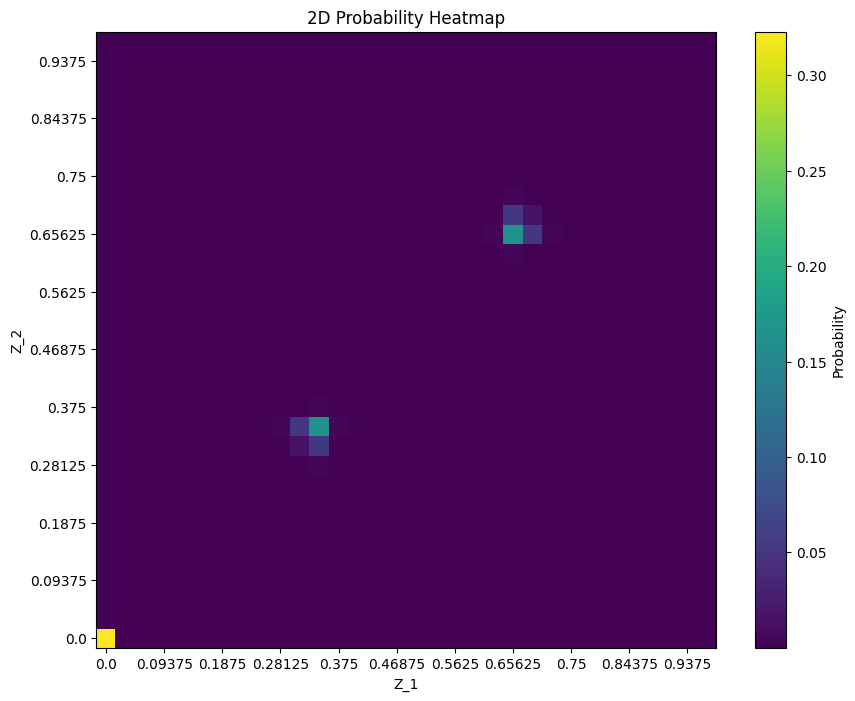

In [27]:
dimension = 2
qb_per_dim = 5

qc = regev_qc(21, 2, 5, 30, bits_function_21_2_5)
# Get the final statevector after applying the circuit
statevector = Statevector.from_instruction(qc)

# Calculate probabilities by taking the diagonal elements of the reduced density matrix
probabilities = statevector.probabilities(range(dimension*qb_per_dim))
print(probabilities)

data=qcu.generate_labels(probabilities, qb_per_dim, dimension)

qcu.plot_2d_distribution(data, "final_plot_21_2_5")



In [28]:
sample_vector(data, 10, 32)

[(0.0, 0.0),
 (0.34375, 0.34375),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.34375, 0.3125),
 (0.65625, 0.65625),
 (0.0, 0.0),
 (0.65625, 0.65625),
 (0.0, 0.0)]

qbits used: 11


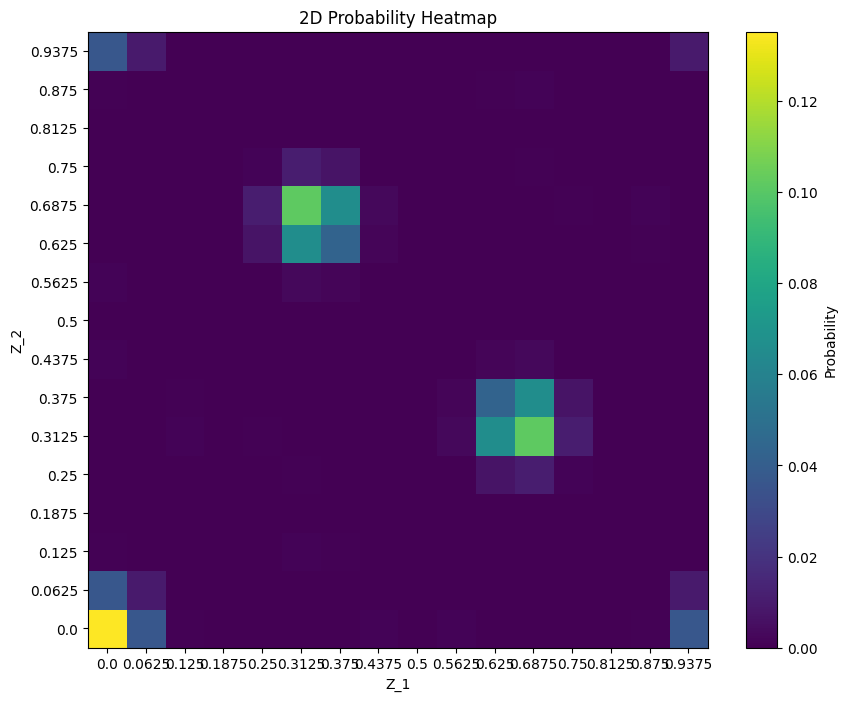

In [29]:
dimension = 2
qb_per_dim = 4

qc = regev_qc(14, dimension, qb_per_dim, 5, bits_function_14_3_5)
# Get the final statevector after applying the circuit
statevector = Statevector.from_instruction(qc)

# Calculate probabilities by taking the diagonal elements of the reduced density matrix
probabilities = statevector.probabilities(range(dimension*qb_per_dim))

data=qcu.generate_labels(probabilities, qb_per_dim, dimension)
qcu.plot_2d_distribution(data, "final_plot_14_3_5")

qbits used: 10


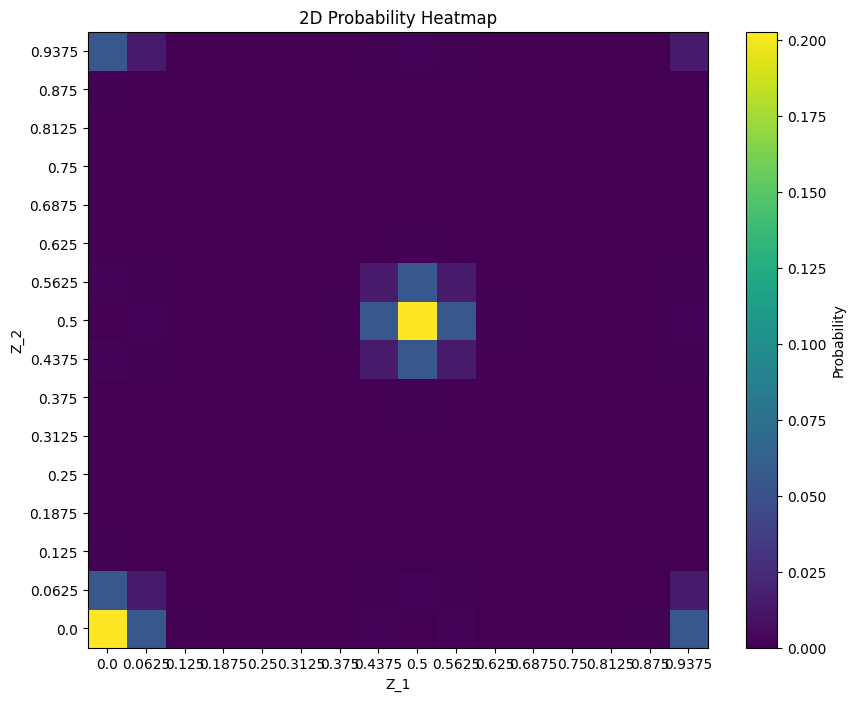

In [30]:
dimension = 2
qb_per_dim = 4

qc = regev_qc(15, dimension, qb_per_dim, 5, bits_function_15_2_7)
# Get the final statevector after applying the circuit
statevector = Statevector.from_instruction(qc)

# Calculate probabilities by taking the diagonal elements of the reduced density matrix
probabilities = statevector.probabilities(range(dimension*qb_per_dim))

data=qcu.generate_labels(probabilities, qb_per_dim, dimension)
qcu.plot_2d_distribution(data, "final_plot_15_2_7")